In [233]:
%matplotlib inline
import pandas as pd
import numpy as np
import tables as tb
import datetime
import os

from scipy.fftpack import rfft, fftshift, fft
from scipy.optimize import least_squares
from numpy import pi
from scipy.signal import tukey, bartlett, iirnotch, freqz, lfilter, sosfilt, sos2tf
from scipy.signal import correlate
from itertools import product

from matplotlib import pyplot as plt; plt.rcParams['figure.figsize'] = 15, 5

DATA_DIR = '../data/interim/'
HDF_FILE = 'interim_data.hdf'

In [20]:
D = pd.read_hdf(DATA_DIR + HDF_FILE, key = '/temperature_ts/wban_94797/D')
t = D.index
T = D['T'].values
T = T - np.mean(T)

In [22]:
N = len(T)  # number of discrete frequenies
T_sample = 3600.  # 1 sample every hour
ST = fft(T)[0: N // 2]
f = np.linspace(0, 1 / (2 * T_sample), N // 2)  # Frequency in Hz
ST = pd.DataFrame(index=f, data=np.abs(ST))

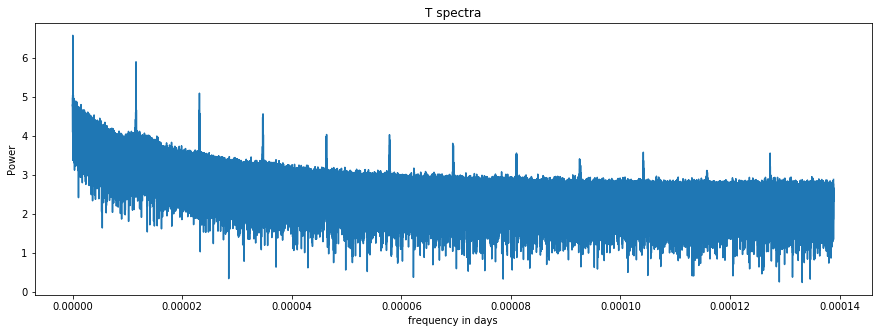

In [23]:
plt.plot(ST.index[1:], np.log10(ST.values)[1:])
#plt.plot(f[1:N_final], 20.0 / len(T) * np.log10(np.abs(ST[1:N_final])))
plt.xlabel('frequency in days')
plt.ylabel('Power')
plt.title('T spectra')

In [37]:
a = np.argsort(-ST.values.flatten())

# Frequeny in units of days
f_yr = ST.index[a[0]]
f_d = ST.index[a[1]]
print(f0_yr, f0_d)

3.16568360015e-08 1.15742262704e-05


In [201]:
fs = 1./(3600)  # Sample frequency (Hz)
n_filts = 11
Q = [.125, 40, 60, 120, 140, 190, 200, 300, 350, 425, 550, 600]*2  # Quaity factors
print('Nyquist Freq:', fs/2)  # Nyquist frequency
cfreqs = [f_yr] + [k*f_d for k in range(1, n_filts + 1)]
cfreqs = [fc / (fs / 2) for fc in cfreqs]*2  # Normalize
print('cfreqs:', cfreqs)

SOS = 1
del SOS

# Design notch filter
for w0, q in zip(cfreqs, Q):
    b, a = iirnotch(w0, q)
    sos = np.append(b, a)
    try:
        SOS = np.vstack((SOS, sos))
    except NameError:
        SOS = sos

b, a = sos2tf(SOS)

Nyquist Freq: 0.0001388888888888889
cfreqs: [0.0002279292192109266, 0.083334429146887226, 0.16666885829377445, 0.25000328744066169, 0.3333377165875489, 0.41667214573443612, 0.50000657488132338, 0.58334100402821065, 0.66667543317509781, 0.75000986232198497, 0.83334429146887223, 0.91667872061575961, 0.0002279292192109266, 0.083334429146887226, 0.16666885829377445, 0.25000328744066169, 0.3333377165875489, 0.41667214573443612, 0.50000657488132338, 0.58334100402821065, 0.66667543317509781, 0.75000986232198497, 0.83334429146887223, 0.91667872061575961]


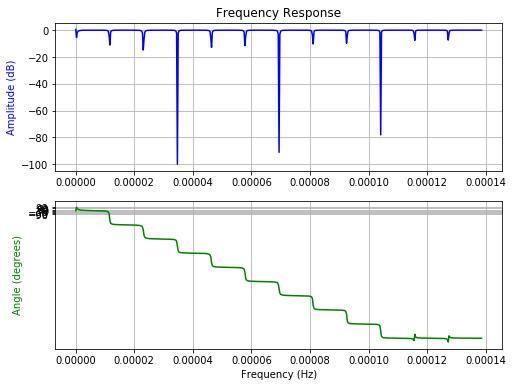

In [202]:
# Frequency response
w, h = freqz(b, a)
# Generate frequency axis
freq = w*fs/(2*np.pi)
# Plot
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(freq, 20*np.log10(abs(h)), color='blue')
ax[0].set_title("Frequency Response")
ax[0].set_ylabel("Amplitude (dB)", color='blue')
ax[0].grid()
ax[1].plot(freq, np.unwrap(np.angle(h))*180/np.pi, color='green')
ax[1].set_ylabel("Angle (degrees)", color='green')
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_yticks([-90, -60, -30, 0, 30, 60, 90])
ax[1].grid()
plt.show()

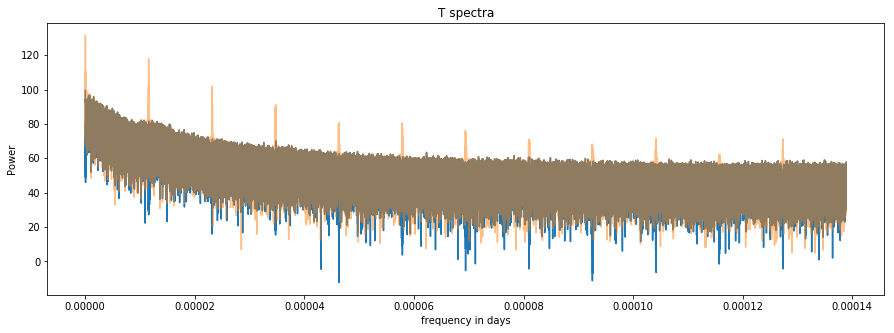

In [235]:
T_filt = sosfilt(SOS, T)
T_filt = T_filt - np.mean(T_filt)
D['T_filt'] = T_filt
ST_filt = fft(T_filt)[0: N // 2]
ST_filt = pd.DataFrame(index=f, data=np.abs(ST_filt))
plt.plot(ST_filt.index[1:], 20*np.log10(ST_filt.values)[1:])
plt.plot(ST.index[1:], 20*np.log10(ST.values)[1:], alpha = 0.5)
#plt.plot(f[1:N_final], 20.0 / len(T) * np.log10(np.abs(ST[1:N_final])))
plt.xlabel('frequency in days')
plt.ylabel('Power')
plt.title('T spectra')

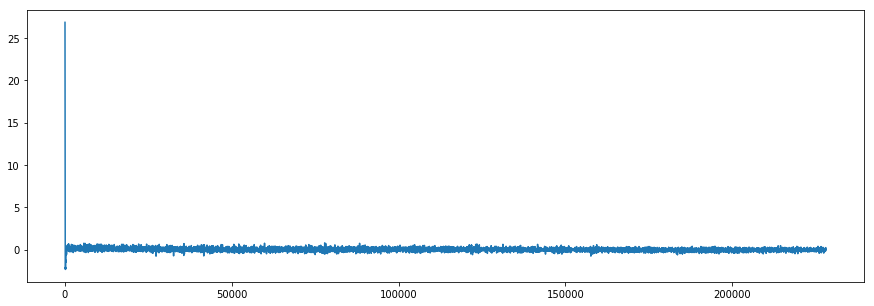

In [204]:
rx_filt = (1. / N) * correlate(T_filt, T_filt, mode = 'same')
plt.plot(fftshift(rx_filt)[0:N//2])

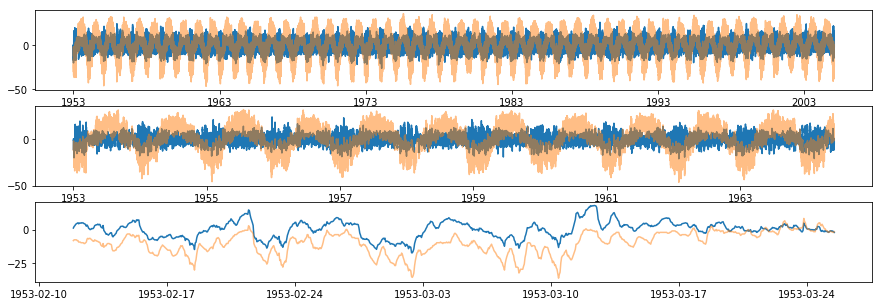

In [236]:
fig, axes = plt.subplots(3, 1)
ax0, ax1, ax2 = axes
ax0.plot(t, T_filt); ax0.plot(t, T, alpha=0.5)
ax1.plot(t[0:100000], T_filt[0:100000]); ax1.plot(t[0:100000], T[0:100000], alpha=0.5)
ax2.plot(t[1000:2000], T_filt[1000:2000]); ax2.plot(t[1000:2000], T[1000:2000], alpha=0.5)

In [237]:
t_days = [t[np.logical_and(t.month == m, t.day == d)] for m, d in product(range(1,13), range(1, 32))]

In [240]:
T_filt = D['T_filt']
day_vars = pd.Series(T_filt[ti].var() for ti in t_days)
day_vars = day_vars.dropna()

In [244]:
T = D['T']
day_varsT = pd.Series(T[ti].var() for ti in t_days)
day_varsT = day_varsT.dropna()

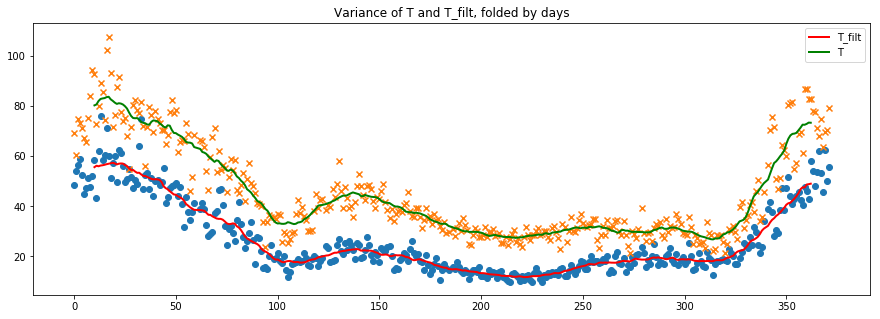

In [246]:
plt.scatter(day_vars.index, day_vars)
plt.scatter(day_varsT.index, day_varsT, marker='x')
r = day_vars.rolling(window = 20, center = True)
rT = day_varsT.rolling(window=20, center=True)
plt.plot(day_vars.index, r.mean(), color = 'red', linewidth = 2, label = 'T_filt')
plt.plot(day_varsT.index, rT.mean(), color = 'green', linewidth=2, label = 'T')
plt.title('Variance of T and T_filt, folded by days')
plt.legend()